In [94]:
# from torch.utils.data import DataLoader
from monai.metrics import DiceMetric
from monai.data import (
    DataLoader,
    Dataset,
    decollate_batch,
)
from tqdm import tqdm
import os
import pandas as pd
import numpy as np

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    MapTransform,
    ScaleIntensityd,
    # AddChanneld,
    SpatialPadd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    ConcatItemsd,
    AdjustContrastd, 
    Rand3DElasticd,
    HistogramNormalized,
    NormalizeIntensityd

)

# def dict_collate(batch):
#     """
#     Custom collate function that flattens the batch if each element is a list
#     (e.g. from RandCropByPosNegLabeld producing multiple crops) and returns
#     a dictionary with keys "ct" and "seg" having stacked tensors.
#     """
#     flattened = []
#     for sample in batch:
#         if isinstance(sample, list):
#             flattened.extend(sample)
#         else:
#             flattened.append(sample)
    
#     collated = {}
#     # Iterate over keys in the first sample.
#     for key in flattened[0].keys():
#         # Check the type of the first element for this key.
#         first_item = flattened[0][key]
#         if isinstance(first_item, torch.Tensor):
#             collated[key] = torch.stack([item[key] for item in flattened])
#         else:
#             collated[key] = [item[key] for item in flattened]
#     return collated

class HectorMONAIDataset_segmentation:
    def __init__(self, data_folder, csv_file, seg_folder):
        self.data_folder = data_folder
        self.seg_folder = seg_folder
        self.dataframe = pd.read_csv(csv_file)
        self.samples = self.prepare_samples()

    def prepare_samples(self):
        samples = []
        # Iterate over each row in the CSV.
        for idx, row in tqdm(self.dataframe.iterrows()):
            patient_id = row['PatientID']
            # Build filepaths based on the patient ID.
            # ct_filename = patient_id + "_ct_roi.npz"
            ct_filename = patient_id + "_ct_roi.nii.gz"
            ct_filepath = os.path.join(self.data_folder, ct_filename)
            seg_filename = patient_id + "_mask_roi.nii.gz"
            seg_filepath = os.path.join(self.seg_folder, seg_filename)
            # Retrieve the hidden state from the embedding dictionary.
            fold = row['fold']
            # Build a dictionary sample.
            sample = {
                "ct": ct_filepath,
                "seg": seg_filepath,
                "fold": fold,
            }
            samples.append(sample)
        return samples

    def train_val_split(self, fold, train_transforms: Compose, val_transforms: Compose):
        train_samples = [s for s in self.samples if s["fold"] != fold]
        val_samples = [s for s in self.samples if s["fold"] == fold]
        train_ds = Dataset(data=train_samples, transform=train_transforms)
        val_ds = Dataset(data=val_samples, transform=val_transforms)
        return train_ds, val_ds

def get_loader_segmentation(ct_path, seg_folder, csv_file, fold): 

    train_transforms = Compose(
        [
            LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
            Orientationd(keys=["ct", "seg"], axcodes="PLS"),
            RandCropByPosNegLabeld(
                keys=["ct", "seg"],
                label_key="seg",
                spatial_size=(96, 96, 96),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="ct",
                image_threshold=0,
            ),
            RandFlipd(
                keys=["ct", "seg"],
                spatial_axis=[0],
                prob=0.20,
            ),
            RandFlipd(
                keys=["ct", "seg"],
                spatial_axis=[1],
                prob=0.20,
            ),
            RandFlipd(
                keys=["ct", "seg"],
                spatial_axis=[2],
                prob=0.20,
            ),
            RandRotate90d(
                keys=["ct", "seg"],
                prob=0.20,
                max_k=3,
            ),
        ]
    )
    val_transforms = Compose(
        [
            LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
            Orientationd(keys=["ct", "seg"], axcodes="PLS"),
        ]
    )

    hector_data = HectorMONAIDataset_segmentation(data_folder=ct_path, csv_file=csv_file, seg_folder=seg_folder)

    train_ds, val_ds = hector_data.train_val_split(fold=fold, train_transforms=train_transforms, val_transforms=val_transforms)

    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

    return train_loader, val_loader

train_loader, test_loader = get_loader_segmentation(ct_path = '/share/sda/mohammadqazi/project/hector/dataset/processed_samples_all',
        csv_file ="/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/TNM_hector_prompts.csv",
        seg_folder = '/share/sda/mohammadqazi/project/hector/dataset/processed_samples_all',
        fold = 0)


409it [00:00, 16423.69it/s]


In [2]:
sample = next(iter(train_loader))

In [59]:
test_sample = next(iter(test_loader))

image shape: torch.Size([1, 480, 480, 240]), label shape: torch.Size([1, 480, 480, 240])


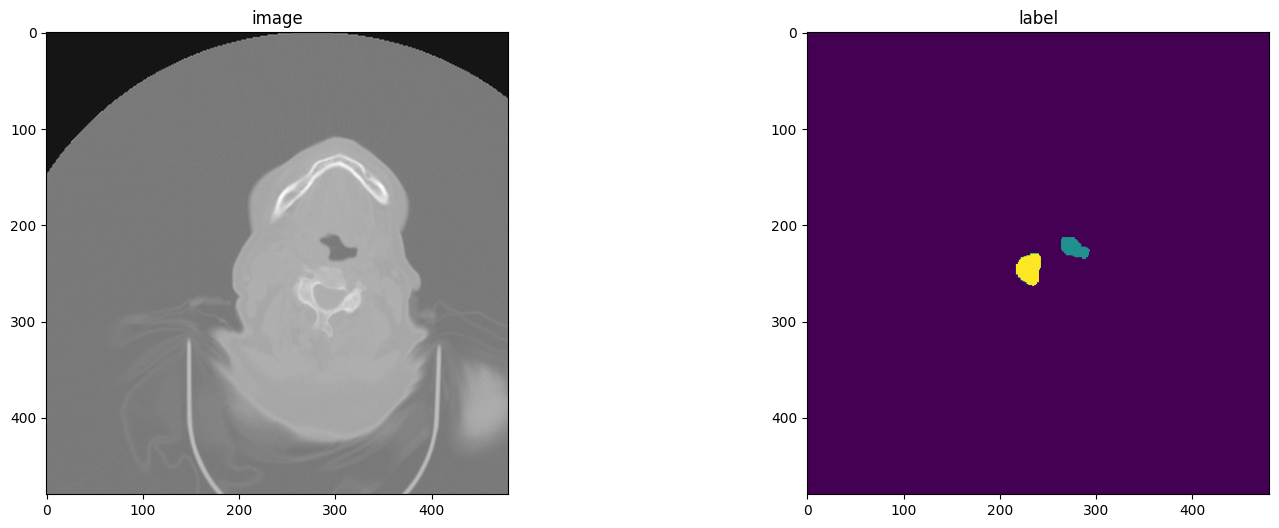

In [69]:
import matplotlib.pyplot as plt

img = test_sample['ct'].squeeze(0)
label = test_sample['seg'].squeeze(0)
slice_num = 65
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_num].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_num].detach().cpu())
plt.show()

In [95]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from monai.networks.nets import UNETR
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=512,
    mlp_dim=3072,
    num_heads=4,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [97]:
from monai.metrics import DiceMetric
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

root_dir  = '/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/CT-CLIP/scripts/'

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["ct"].cuda(), batch["seg"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["ct"].cuda(), batch["seg"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(test_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 20
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (20 / 25000 Steps) (loss=1.28913):   6%|▌         | 20/327 [00:48<12:29,  2.44s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 634.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 65.44 MiB is free. Process 1083399 has 1.93 GiB memory in use. Including non-PyTorch memory, this process has 9.45 GiB memory in use. Process 1437960 has 6.10 GiB memory in use. Process 1516114 has 6.12 GiB memory in use. Of the allocated memory 5.78 GiB is allocated by PyTorch, and 3.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

In [31]:
from collections.abc import Sequence
import torch.nn as nn

from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.blocks.unetr_block import UnetrBasicBlock, UnetrPrUpBlock, UnetrUpBlock
from monai.networks.nets.vit import ViT
from monai.utils import ensure_tuple_rep

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class UNETR(nn.Module):
    """
    UNETR based on: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        img_size: Sequence[int] | int,
        feature_size: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        proj_type: str = "conv",
        norm_name: tuple | str = "instance",
        conv_block: bool = True,
        res_block: bool = True,
        dropout_rate: float = 0.0,
        spatial_dims: int = 3,
        qkv_bias: bool = False,
        save_attn: bool = False,
    ) -> None:
        """
        Args:
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            img_size: dimension of input image.
            feature_size: dimension of network feature size. Defaults to 16.
            hidden_size: dimension of hidden layer. Defaults to 768.
            mlp_dim: dimension of feedforward layer. Defaults to 3072.
            num_heads: number of attention heads. Defaults to 12.
            proj_type: patch embedding layer type. Defaults to "conv".
            norm_name: feature normalization type and arguments. Defaults to "instance".
            conv_block: if convolutional block is used. Defaults to True.
            res_block: if residual block is used. Defaults to True.
            dropout_rate: fraction of the input units to drop. Defaults to 0.0.
            spatial_dims: number of spatial dims. Defaults to 3.
            qkv_bias: apply the bias term for the qkv linear layer in self attention block. Defaults to False.
            save_attn: to make accessible the attention in self attention block. Defaults to False.

        Examples::

            # for single channel input 4-channel output with image size of (96,96,96), feature size of 32 and batch norm
            >>> net = UNETR(in_channels=1, out_channels=4, img_size=(96,96,96), feature_size=32, norm_name='batch')

             # for single channel input 4-channel output with image size of (96,96), feature size of 32 and batch norm
            >>> net = UNETR(in_channels=1, out_channels=4, img_size=96, feature_size=32, norm_name='batch', spatial_dims=2)

            # for 4-channel input 3-channel output with image size of (128,128,128), conv position embedding and instance norm
            >>> net = UNETR(in_channels=4, out_channels=3, img_size=(128,128,128), proj_type='conv', norm_name='instance')

        """

        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise ValueError("dropout_rate should be between 0 and 1.")

        if hidden_size % num_heads != 0:
            raise ValueError("hidden_size should be divisible by num_heads.")

        self.num_layers = 12
        img_size = ensure_tuple_rep(img_size, spatial_dims)
        self.patch_size = ensure_tuple_rep(16, spatial_dims)
        self.feat_size = tuple(img_d // p_d for img_d, p_d in zip(img_size, self.patch_size))
        self.hidden_size = hidden_size
        self.classification = False
        self.vit = ViT(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=self.patch_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_layers=self.num_layers,
            num_heads=num_heads,
            proj_type=proj_type,
            classification=self.classification,
            dropout_rate=dropout_rate,
            spatial_dims=spatial_dims,
            qkv_bias=qkv_bias,
            save_attn=save_attn,
        )
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder3 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder4 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)
        self.proj_axes = (0, spatial_dims + 1) + tuple(d + 1 for d in range(spatial_dims))
        self.proj_view_shape = list(self.feat_size) + [self.hidden_size]

    def proj_feat(self, x):
        print(self.proj_view_shape)
        new_view = [x.size(0)] + self.proj_view_shape
        print(new_view)
        x = x.view(new_view)
        x = x.permute(self.proj_axes).contiguous()
        return x

    def forward(self, x_in):
        x, hidden_states_out = self.vit(x_in)
        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[3]
        enc2 = self.encoder2(self.proj_feat(x2))
        x3 = hidden_states_out[6]
        enc3 = self.encoder3(self.proj_feat(x3))
        x4 = hidden_states_out[9]
        enc4 = self.encoder4(self.proj_feat(x4))
        dec4 = self.proj_feat(x)
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1)
        return self.out(out)

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=512,
    mlp_dim=3072,
    num_heads=4,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

In [1]:
model

NameError: name 'model' is not defined

In [32]:
model(torch.rand(1, 1, 96, 96, 96).to(device)).shape

[6, 6, 6, 512]
[1, 6, 6, 6, 512]
[6, 6, 6, 512]
[1, 6, 6, 6, 512]
[6, 6, 6, 512]
[1, 6, 6, 6, 512]
[6, 6, 6, 512]
[1, 6, 6, 6, 512]
torch.Size([1, 64, 24, 24, 24])


torch.Size([1, 3, 96, 96, 96])

In [34]:
model.vit(torch.rand(1, 1, 96, 96, 96).to(device))[0].shape

torch.Size([1, 216, 512])

In [ ]:
from collections.abc import Sequence
import torch.nn as nn

from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.blocks.unetr_block import UnetrBasicBlock, UnetrPrUpBlock, UnetrUpBlock
from monai.networks.nets.vit import ViT
from monai.utils import ensure_tuple_rep

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class UNETR(nn.Module):
    """
    UNETR based on: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        img_size: Sequence[int] | int,
        feature_size: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        proj_type: str = "conv",
        norm_name: tuple | str = "instance",
        conv_block: bool = True,
        res_block: bool = True,
        dropout_rate: float = 0.0,
        spatial_dims: int = 3,
        qkv_bias: bool = False,
        save_attn: bool = False,
    ) -> None:
        """
        Args:
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            img_size: dimension of input image.
            feature_size: dimension of network feature size. Defaults to 16.
            hidden_size: dimension of hidden layer. Defaults to 768.
            mlp_dim: dimension of feedforward layer. Defaults to 3072.
            num_heads: number of attention heads. Defaults to 12.
            proj_type: patch embedding layer type. Defaults to "conv".
            norm_name: feature normalization type and arguments. Defaults to "instance".
            conv_block: if convolutional block is used. Defaults to True.
            res_block: if residual block is used. Defaults to True.
            dropout_rate: fraction of the input units to drop. Defaults to 0.0.
            spatial_dims: number of spatial dims. Defaults to 3.
            qkv_bias: apply the bias term for the qkv linear layer in self attention block. Defaults to False.
            save_attn: to make accessible the attention in self attention block. Defaults to False.

        Examples::

            # for single channel input 4-channel output with image size of (96,96,96), feature size of 32 and batch norm
            >>> net = UNETR(in_channels=1, out_channels=4, img_size=(96,96,96), feature_size=32, norm_name='batch')

             # for single channel input 4-channel output with image size of (96,96), feature size of 32 and batch norm
            >>> net = UNETR(in_channels=1, out_channels=4, img_size=96, feature_size=32, norm_name='batch', spatial_dims=2)

            # for 4-channel input 3-channel output with image size of (128,128,128), conv position embedding and instance norm
            >>> net = UNETR(in_channels=4, out_channels=3, img_size=(128,128,128), proj_type='conv', norm_name='instance')

        """

        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise ValueError("dropout_rate should be between 0 and 1.")

        if hidden_size % num_heads != 0:
            raise ValueError("hidden_size should be divisible by num_heads.")

        self.num_layers = 12
        img_size = ensure_tuple_rep(img_size, spatial_dims)
        self.patch_size = ensure_tuple_rep(16, spatial_dims)
        self.feat_size = tuple(img_d // p_d for img_d, p_d in zip(img_size, self.patch_size))
        self.hidden_size = hidden_size
        self.classification = False
        self.vit = ViT(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=self.patch_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_layers=self.num_layers,
            num_heads=num_heads,
            proj_type=proj_type,
            classification=self.classification,
            dropout_rate=dropout_rate,
            spatial_dims=spatial_dims,
            qkv_bias=qkv_bias,
            save_attn=save_attn,
        )
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder3 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder4 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)
        self.proj_axes = (0, spatial_dims + 1) + tuple(d + 1 for d in range(spatial_dims))
        self.proj_view_shape = list(self.feat_size) + [self.hidden_size]

    def proj_feat(self, x):
        print(self.proj_view_shape)
        new_view = [x.size(0)] + self.proj_view_shape
        print(new_view)
        x = x.view(new_view)
        x = x.permute(self.proj_axes).contiguous()
        return x

    def forward(self, x_in):
        x, hidden_states_out = self.vit(x_in)
        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[3]
        enc2 = self.encoder2(self.proj_feat(x2))
        x3 = hidden_states_out[6]
        enc3 = self.encoder3(self.proj_feat(x3))
        x4 = hidden_states_out[9]
        enc4 = self.encoder4(self.proj_feat(x4))
        dec4 = self.proj_feat(x)
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1)
        return self.out(out)

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=512,
    mlp_dim=3072,
    num_heads=4,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

In [35]:
import torch
import torch.nn as nn

# Define two Conv3D layers.
conv1 = nn.Conv3d(
    in_channels=512, 
    out_channels=512, 
    kernel_size=3, 
    stride=2, 
    padding=1
)
conv2 = nn.Conv3d(
    in_channels=512, 
    out_channels=512, 
    kernel_size=3, 
    stride=2, 
    padding=1
)

# Example input: shape (batch_size, channels, depth, height, width)
x = torch.randn(1, 512, 24, 24, 24)

# First step: reduce spatial dims from 24 to 12.
x1 = conv1(x)
print("After conv1:", x1.shape)  # Expected: (1, 512, 12, 12, 12)

# Second step: reduce spatial dims from 12 to 6.
x2 = conv2(x1)
print("After conv2:", x2.shape)  # Expected: (1, 512, 6, 6, 6)


After conv1: torch.Size([1, 512, 12, 12, 12])
After conv2: torch.Size([1, 512, 6, 6, 6])


In [1]:
# from transformer_maskgit import CTViT
from beartype import beartype
from typing import Tuple
import torch.nn.functional as F



import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch import nn, einsum
from einops.layers.torch import Rearrange
from einops import rearrange, repeat, pack, unpack


def pair(val):
    ret = (val, val) if not isinstance(val, tuple) else val
    assert len(ret) == 2
    return ret

def leaky_relu(p = 0.1):
    return nn.LeakyReLU(p)
    
def default(val, d):
    return val if exists(val) else d

def exists(val):
    return val is not None

def l2norm(t):
    return F.normalize(t, dim = -1)
    
class ContinuousPositionBias(nn.Module):
    """ from https://arxiv.org/abs/2111.09883 """

    def __init__(
        self,
        *,
        dim,
        heads,
        num_dims = 2, # 2 for images, 3 for video
        layers = 2,
        log_dist = True,
        cache_rel_pos = False
    ):
        super().__init__()
        self.num_dims = num_dims
        self.log_dist = log_dist

        self.net = nn.ModuleList([])
        self.net.append(nn.Sequential(nn.Linear(self.num_dims, dim), leaky_relu()))

        for _ in range(layers - 1):
            self.net.append(nn.Sequential(nn.Linear(dim, dim), leaky_relu()))

        self.net.append(nn.Linear(dim, heads))

        self.cache_rel_pos = cache_rel_pos
        self.register_buffer('rel_pos', None, persistent = False)

    def forward(self, *dimensions, device = torch.device('cpu')):

        if not exists(self.rel_pos) or not self.cache_rel_pos:
            device=torch.device('cuda')
            positions = [torch.arange(d, device = device) for d in dimensions]
            grid = torch.stack(torch.meshgrid(*positions, indexing = 'ij'))
            grid = rearrange(grid, 'c ... -> (...) c')
            rel_pos = rearrange(grid, 'i c -> i 1 c') - rearrange(grid, 'j c -> 1 j c')

            if self.log_dist:
                rel_pos = torch.sign(rel_pos) * torch.log(rel_pos.abs() + 1)

            self.register_buffer('rel_pos', rel_pos, persistent = False)

        rel_pos = self.rel_pos.to(torch.float32)

        for layer in self.net:
            rel_pos = layer(rel_pos.float())

        return rearrange(rel_pos, 'i j h -> h i j')

class Transformer(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth,
        dim_context = None,
        causal = False,
        dim_head = 64,
        heads = 8,
        ff_mult = 4,
        peg = False,
        peg_causal = False,
        attn_num_null_kv = 2,
        has_cross_attn = False,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PEG(dim = dim, causal = peg_causal) if peg else None,
                Attention(dim = dim, dim_head = dim_head, heads = heads, causal = causal, dropout = attn_dropout),
                Attention(dim = dim, dim_head = dim_head, dim_context = dim_context, heads = heads, causal = False, num_null_kv = attn_num_null_kv, dropout = attn_dropout) if has_cross_attn else None,
                FeedForward(dim = dim, mult = ff_mult, dropout = ff_dropout)
            ]))

        self.norm_out = LayerNorm(dim)

    @beartype
    def forward(
        self,
        x,
        video_shape: Tuple[int, int, int, int] = None,
        attn_bias = None,
        context = None,
        self_attn_mask = None,
        cross_attn_context_mask = None
    ):

        hidden_state = []
        for peg, self_attn, cross_attn, ff in self.layers:
            if exists(peg):
                x = peg(x, shape = video_shape) + x

            x = self_attn(x, attn_bias = attn_bias, mask = self_attn_mask) + x

            if exists(cross_attn) and exists(context):
                x = cross_attn(x, context = context, mask = cross_attn_context_mask) + x

            x = ff(x) + x

            # hidden_state.append(x.reshape(int(x.shape[0]/24), 13824, 512))
            # hidden_state.append(x.reshape(int(x.shape[0]/24), 512, 24, 24, 24))
            hidden_state.append(x)

        return self.norm_out(x), hidden_state

class PEG(nn.Module):
    def __init__(self, dim, causal = False):
        super().__init__()
        self.causal = causal
        self.dsconv = nn.Conv3d(dim, dim, 3, groups = dim)

    @beartype
    def forward(self, x, shape: Tuple[int, int, int, int] = None):
        needs_shape = x.ndim == 3
        assert not (needs_shape and not exists(shape))

        # breakpoint()
        orig_shape = x.shape

        if needs_shape:
            x = x.reshape(*shape, -1)

        x = rearrange(x, 'b ... d -> b d ...')

        frame_padding = (2, 0) if self.causal else (1, 1)

        x = F.pad(x, (1, 1, 1, 1, *frame_padding), value = 0.)
        x = self.dsconv(x)

        x = rearrange(x, 'b d ... -> b ... d')

        if needs_shape:
            x = rearrange(x, 'b ... d -> b (...) d')

        return x.reshape(orig_shape)

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_context = None,
        dim_head = 64,
        heads = 8,
        causal = False,
        num_null_kv = 0,
        norm_context = True,
        dropout = 0.,
        scale = 8
    ):
        super().__init__()
        self.heads = heads
        self.causal = causal
        self.scale = scale
        inner_dim = dim_head * heads
        dim_context = default(dim_context, dim)

        if causal:
            self.rel_pos_bias = AlibiPositionalBias(heads = heads)

        self.attn_dropout = nn.Dropout(dropout)

        self.norm = LayerNorm(dim)
        self.context_norm = LayerNorm(dim_context) if norm_context else nn.Identity()

        self.num_null_kv = num_null_kv
        self.null_kv = nn.Parameter(torch.randn(heads, 2 * num_null_kv, dim_head))

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim_context, inner_dim * 2, bias = False)

        self.q_scale = nn.Parameter(torch.ones(dim_head))
        self.k_scale = nn.Parameter(torch.ones(dim_head))

        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(
        self,
        x,
        mask = None,
        context = None,
        attn_bias = None
    ):
        batch, device, dtype = x.shape[0], x.device, x.dtype
        device=torch.device('cuda')
        if exists(context):
            context = self.context_norm(context)

        kv_input = default(context, x)

        x = self.norm(x)

        q, k, v = self.to_q(x), *self.to_kv(kv_input).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), (q, k, v))

        nk, nv = repeat(self.null_kv, 'h (n r) d -> b h n r d', b = batch, r = 2).unbind(dim = -2)

        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        q, k = map(l2norm, (q, k))
        q = q * self.q_scale
        k = k * self.k_scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        i, j = sim.shape[-2:]

        if exists(attn_bias):
            attn_bias = F.pad(attn_bias, (self.num_null_kv, 0), value = 0.)
            sim = sim + attn_bias

        if exists(mask):
            mask = F.pad(mask, (self.num_null_kv, 0), value = True)
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)

        if self.causal:
            sim = sim + self.rel_pos_bias(sim)
            device=torch.device('cuda')
            causal_mask = torch.ones((i, j), device = device, dtype = torch.bool).triu(j - i + 1)
            sim = sim.masked_fill(causal_mask, -torch.finfo(sim.dtype).max)

        attn = sim.softmax(dim = -1)
        attn = self.attn_dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.register_buffer("beta", torch.zeros(dim))

    def forward(self, x):
        return F.layer_norm(x, x.shape[-1:], self.gamma, self.beta)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim = -1)
        return F.gelu(gate) * x

def FeedForward(dim, mult = 4, dropout = 0.):
    inner_dim = int(mult * (2 / 3) * dim)
    return nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, inner_dim * 2, bias = False),
        GEGLU(),
        nn.Dropout(dropout),
        nn.Linear(inner_dim, dim, bias = False)
    )
      
class CTViT(nn.Module):
    def __init__(
        self,
        *,
        dim,
        codebook_size,
        image_size,
        patch_size,
        temporal_patch_size,
        spatial_depth,
        temporal_depth,
        discr_base_dim = 16,
        dim_head = 64,
        heads = 8,
        channels = 1,
        use_vgg_and_gan = True,
        vgg = None,
        discr_attn_res_layers = (16,),
        use_hinge_loss = True,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):

        super().__init__()

        self.image_size = pair(image_size)
        self.patch_size = pair(patch_size)
        patch_height, patch_width = self.patch_size

        self.spatial_rel_pos_bias = ContinuousPositionBias(dim = dim, heads = heads)

        image_height, image_width = self.image_size
        assert (image_height % patch_height) == 0 and (image_width % patch_width) == 0

        # self.to_patch_emb = nn.Sequential(
        #     Rearrange('b c (t pt) (h p1) (w p2) -> b t h w (c pt p1 p2)', p1 = patch_height, p2 = patch_width, pt = temporal_patch_size),
        #     nn.LayerNorm(channels * patch_width * patch_height * temporal_patch_size),
        #     nn.Linear(channels * patch_width * patch_height * temporal_patch_size, dim),
        #     nn.LayerNorm(dim)
        # )

        self.to_patch_emb = nn.Sequential(
            Rearrange('b c (t pt) (h p1) (w p2) -> b t h w (c pt p1 p2)', p1 = 20, p2 = 20, pt = 10),
            nn.LayerNorm(channels * 20 * 20 * 10),
            nn.Linear(channels * 20 * 20 * 10, dim),
            nn.LayerNorm(dim)
        )

        self.to_patch_emb_head_neck_ct = nn.Sequential(
            Rearrange('b c (t pt) (h p1) (w p2) -> b t h w (c pt p1 p2)', p1 = patch_height, p2 = patch_width, pt = temporal_patch_size),
            nn.LayerNorm(channels * patch_width * patch_height * temporal_patch_size),
            nn.Linear(channels * patch_width * patch_height * temporal_patch_size, dim),
            nn.LayerNorm(dim)
        )

        transformer_kwargs = dict(
            dim = dim,
            dim_head = dim_head,
            heads = heads,
            attn_dropout = attn_dropout,
            ff_dropout = ff_dropout,
            peg = True,
            peg_causal = True,
        )
        self.enc_spatial_transformer = Transformer(depth = spatial_depth, **transformer_kwargs)

    @property
    def patch_height_width(self):
        return self.image_size[0] // self.patch_size[0], self.image_size[1] // self.patch_size[1]

    def encode(
        self,
        tokens,
        only_spatial = False
    ):
        b = tokens.shape[0]
        h, w = self.patch_height_width

        video_shape = tuple(tokens.shape[:-1])

        tokens = rearrange(tokens, 'b t h w d -> (b t) (h w) d')
        device=torch.device('cuda')
        attn_bias = self.spatial_rel_pos_bias(h, w, device = device)


        tokens, hidden_state = self.enc_spatial_transformer(tokens, attn_bias = attn_bias, video_shape = video_shape)

        tokens = rearrange(tokens, '(b t) (h w) d -> b t h w d', b = b, h = h , w = w)

        if only_spatial:
            return tokens, hidden_state

    def forward(
        self,
        video,
        mask = None,
        return_recons = False,
        return_recons_only = False,
        return_discr_loss = False,
        apply_grad_penalty = True,
        return_only_codebook_ids = False,
        return_encoded_tokens=False,
        return_spatial_tokens=False
    ):
        assert video.ndim in {4, 5}

        is_image = video.ndim == 4
        #print(video.shape)

        if is_image:
            video = rearrange(video, 'b c h w -> b c 1 h w')
            assert not exists(mask)

        b, c, f, *image_dims, device = *video.shape, video.device
        device=torch.device('cuda')
        # assert tuple(image_dims) == self.image_size
        # assert not exists(mask) or mask.shape[-1] == f

        # tokens = self.to_patch_emb(video)
        tokens = self.to_patch_emb_head_neck_ct(video)
        # print(tokens.shape)

        shape = tokens.shape
        *_, h, w, _ = shape

        # encode - spatial

        tokens, hidden_state = self.encode(tokens, only_spatial = True)

        return tokens, hidden_state


In [2]:
image_encoder = CTViT(
    dim = 512,
    codebook_size = 8192,
    # image_size = 480,
    # patch_size = 20,
    # temporal_patch_size = 10,
    image_size = 96,
    patch_size = 24,
    temporal_patch_size = 24,
    spatial_depth = 4,
    temporal_depth = 4,
    dim_head = 32,
    heads = 8
).to(device)

In [3]:
# image_encoder.to_patch_emb_head_neck_ct(torch.randn(1, 1, 96, 96, 96).to(device)).shape
image_encoder.to_patch_emb_head_neck_ct(torch.randn(1, 1, 96, 96, 96).to(device)).shape

torch.Size([1, 4, 4, 4, 512])

In [4]:
image_encoder.encode(torch.randn(1, 4, 4, 4, 512).to(device), only_spatial = True)[1][-1].shape

torch.Size([4, 16, 512])

In [7]:
image_encoder.encode(torch.randn(1, 24, 24, 24, 512).to(device), only_spatial = True)[0].shape

torch.Size([1, 24, 24, 24, 512])

In [6]:
# image_encoder(torch.randn(1, 1, 240, 480, 480).to(device))[0].shape
image_encoder.encode(torch.randn(1, 24, 24, 24, 512).to(device), only_spatial = True)[0].shape

RuntimeError: shape '[1, 512, 24, 24, 24]' is invalid for input of size 7372800

In [13]:
pt = torch.load(str('/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/CT-CLIP_v2.pt'))
# replace "visual_transformer" from the state_dict keys if available
pt = {k.replace('visual_transformer.', ''): v for k, v in pt.items()}

/tmp/ipykernel_2712256/3493283662.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt = torch.load(str('/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/CT-

In [14]:
image_encoder.load_state_dict(pt, strict=False)

_IncompatibleKeys(missing_keys=['to_patch_emb_head_neck_ct.1.weight', 'to_patch_emb_head_neck_ct.1.bias', 'to_patch_emb_head_neck_ct.2.weight', 'to_patch_emb_head_neck_ct.2.bias', 'to_patch_emb_head_neck_ct.3.weight', 'to_patch_emb_head_neck_ct.3.bias'], unexpected_keys=['temperature', 'text_transformer.embeddings.position_ids', 'text_transformer.embeddings.word_embeddings.weight', 'text_transformer.embeddings.position_embeddings.weight', 'text_transformer.embeddings.token_type_embeddings.weight', 'text_transformer.embeddings.LayerNorm.weight', 'text_transformer.embeddings.LayerNorm.bias', 'text_transformer.encoder.layer.0.attention.self.query.weight', 'text_transformer.encoder.layer.0.attention.self.query.bias', 'text_transformer.encoder.layer.0.attention.self.key.weight', 'text_transformer.encoder.layer.0.attention.self.key.bias', 'text_transformer.encoder.layer.0.attention.self.value.weight', 'text_transformer.encoder.layer.0.attention.self.value.bias', 'text_transformer.encoder.lay

In [2]:
from collections.abc import Sequence
import torch.nn as nn

from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.blocks.unetr_block import UnetrBasicBlock, UnetrPrUpBlock, UnetrUpBlock
from monai.networks.nets.vit import ViT
from monai.utils import ensure_tuple_rep

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn

class DownsampleBlock(nn.Module):
    def __init__(self, in_channels: int = 512, out_channels: int = 512, 
                 kernel_size: int = 3, stride: int = 2, padding: int = 1):
        super(DownsampleBlock, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.downsample(x)


class UNETR(nn.Module):
    """
    UNETR based on: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        img_size: Sequence[int] | int,
        feature_size: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        proj_type: str = "conv",
        norm_name: tuple | str = "instance",
        conv_block: bool = True,
        res_block: bool = True,
        dropout_rate: float = 0.0,
        spatial_dims: int = 3,
        qkv_bias: bool = False,
        save_attn: bool = False,
    ) -> None:
        """
        Args:
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            img_size: dimension of input image.
            feature_size: dimension of network feature size. Defaults to 16.
            hidden_size: dimension of hidden layer. Defaults to 768.
            mlp_dim: dimension of feedforward layer. Defaults to 3072.
            num_heads: number of attention heads. Defaults to 12.
            proj_type: patch embedding layer type. Defaults to "conv".
            norm_name: feature normalization type and arguments. Defaults to "instance".
            conv_block: if convolutional block is used. Defaults to True.
            res_block: if residual block is used. Defaults to True.
            dropout_rate: fraction of the input units to drop. Defaults to 0.0.
            spatial_dims: number of spatial dims. Defaults to 3.
            qkv_bias: apply the bias term for the qkv linear layer in self attention block. Defaults to False.
            save_attn: to make accessible the attention in self attention block. Defaults to False.

        Examples::

            # for single channel input 4-channel output with image size of (96,96,96), feature size of 32 and batch norm
            >>> net = UNETR(in_channels=1, out_channels=4, img_size=(96,96,96), feature_size=32, norm_name='batch')

             # for single channel input 4-channel output with image size of (96,96), feature size of 32 and batch norm
            >>> net = UNETR(in_channels=1, out_channels=4, img_size=96, feature_size=32, norm_name='batch', spatial_dims=2)

            # for 4-channel input 3-channel output with image size of (128,128,128), conv position embedding and instance norm
            >>> net = UNETR(in_channels=4, out_channels=3, img_size=(128,128,128), proj_type='conv', norm_name='instance')

        """

        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise ValueError("dropout_rate should be between 0 and 1.")

        if hidden_size % num_heads != 0:
            raise ValueError("hidden_size should be divisible by num_heads.")

        self.num_layers = 12
        img_size = ensure_tuple_rep(img_size, spatial_dims)
        self.patch_size = ensure_tuple_rep(16, spatial_dims)
        self.feat_size = tuple(img_d // p_d for img_d, p_d in zip(img_size, self.patch_size))
        self.hidden_size = hidden_size
        self.classification = False
        self.vit = CTViT(
            dim = 512,
            codebook_size = 8192,
            # image_size = 480,
            # patch_size = 20,
            # temporal_patch_size = 10,
            image_size = 96,
            patch_size = 4,
            temporal_patch_size = 4,
            spatial_depth = 4,
            temporal_depth = 4,
            dim_head = 32,
            heads = 8
        )
        self.downsample = nn.ModuleList([DownsampleBlock(in_channels=512, out_channels=512) for _ in range(4)])
        
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder3 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder4 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)
        self.proj_axes = (0, spatial_dims + 1) + tuple(d + 1 for d in range(spatial_dims))
        self.proj_view_shape = list(self.feat_size) + [self.hidden_size]

    def proj_feat(self, x):
        new_view = [x.size(0)] + self.proj_view_shape
        x = x.view(new_view)
        x = x.permute(self.proj_axes).contiguous()
        return x

    def forward(self, x_in):
        x, hidden_states_out = self.vit(x_in)

        for i, down in enumerate(self.downsample):
            if i == 0:
                x = down(x.view(-1, 512, 24, 24, 24))
            elif i == 1:
                hidden_states_out[3] = down(hidden_states_out[3].view(-1, 512, 24, 24, 24))
            elif i == 2:
                hidden_states_out[6] = down(hidden_states_out[6].view(-1, 512, 24, 24, 24))
            elif i == 3:
                hidden_states_out[9] = down(hidden_states_out[9]).view(-1, 512, 24, 24, 24)

        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[3]
        enc2 = self.encoder2(self.proj_feat(x2))
        x3 = hidden_states_out[6]
        enc3 = self.encoder3(self.proj_feat(x3))
        x4 = hidden_states_out[9]
        enc4 = self.encoder4(self.proj_feat(x4))
        dec4 = self.proj_feat(x)
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1)
        return self.out(out)

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=512,
    mlp_dim=3072,
    num_heads=4,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

In [3]:
# image_encoder(torch.randn(1, 1, 240, 480, 480).to(device))[0].shape
model(torch.randn(1, 1, 96, 96, 96).to(device))[0].shape

IndexError: list index out of range

In [23]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_dir  = '/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/CT-CLIP/scripts/'
from monai.networks.nets import UNETR
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference

from collections.abc import Sequence
import torch.nn as nn

from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.blocks.unetr_block import UnetrBasicBlock, UnetrPrUpBlock, UnetrUpBlock
from monai.networks.nets.vit import ViT
from monai.utils import ensure_tuple_rep

import torch
import torch.nn as nn

# from transformer_maskgit import CTViT
from beartype import beartype
from typing import Tuple
import torch.nn.functional as F



import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch import nn, einsum
from einops.layers.torch import Rearrange
from einops import rearrange, repeat, pack, unpack


def pair(val):
    ret = (val, val) if not isinstance(val, tuple) else val
    assert len(ret) == 2
    return ret

def leaky_relu(p = 0.1):
    return nn.LeakyReLU(p)
    
def default(val, d):
    return val if exists(val) else d

def exists(val):
    return val is not None

def l2norm(t):
    return F.normalize(t, dim = -1)
    
class ContinuousPositionBias(nn.Module):
    """ from https://arxiv.org/abs/2111.09883 """

    def __init__(
        self,
        *,
        dim,
        heads,
        num_dims = 2, # 2 for images, 3 for video
        layers = 2,
        log_dist = True,
        cache_rel_pos = False
    ):
        super().__init__()
        self.num_dims = num_dims
        self.log_dist = log_dist

        self.net = nn.ModuleList([])
        self.net.append(nn.Sequential(nn.Linear(self.num_dims, dim), leaky_relu()))

        for _ in range(layers - 1):
            self.net.append(nn.Sequential(nn.Linear(dim, dim), leaky_relu()))

        self.net.append(nn.Linear(dim, heads))

        self.cache_rel_pos = cache_rel_pos
        self.register_buffer('rel_pos', None, persistent = False)

    def forward(self, *dimensions, device = torch.device('cpu')):

        if not exists(self.rel_pos) or not self.cache_rel_pos:
            device=torch.device('cuda')
            positions = [torch.arange(d, device = device) for d in dimensions]
            grid = torch.stack(torch.meshgrid(*positions, indexing = 'ij'))
            grid = rearrange(grid, 'c ... -> (...) c')
            rel_pos = rearrange(grid, 'i c -> i 1 c') - rearrange(grid, 'j c -> 1 j c')

            if self.log_dist:
                rel_pos = torch.sign(rel_pos) * torch.log(rel_pos.abs() + 1)

            self.register_buffer('rel_pos', rel_pos, persistent = False)

        rel_pos = self.rel_pos.to(torch.float32)

        for layer in self.net:
            rel_pos = layer(rel_pos.float())

        return rearrange(rel_pos, 'i j h -> h i j')

class Transformer(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth,
        dim_context = None,
        causal = False,
        dim_head = 64,
        heads = 8,
        ff_mult = 4,
        peg = False,
        peg_causal = False,
        attn_num_null_kv = 2,
        has_cross_attn = False,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PEG(dim = dim, causal = peg_causal) if peg else None,
                Attention(dim = dim, dim_head = dim_head, heads = heads, causal = causal, dropout = attn_dropout),
                Attention(dim = dim, dim_head = dim_head, dim_context = dim_context, heads = heads, causal = False, num_null_kv = attn_num_null_kv, dropout = attn_dropout) if has_cross_attn else None,
                FeedForward(dim = dim, mult = ff_mult, dropout = ff_dropout)
            ]))

        self.norm_out = LayerNorm(dim)

    @beartype
    def forward(
        self,
        x,
        video_shape: Tuple[int, int, int, int] = None,
        attn_bias = None,
        context = None,
        self_attn_mask = None,
        cross_attn_context_mask = None
    ):

        hidden_state = []
        for peg, self_attn, cross_attn, ff in self.layers:
            if exists(peg):
                x = peg(x, shape = video_shape) + x

            x = self_attn(x, attn_bias = attn_bias, mask = self_attn_mask) + x

            if exists(cross_attn) and exists(context):
                x = cross_attn(x, context = context, mask = cross_attn_context_mask) + x

            x = ff(x) + x

            # hidden_state.append(x.reshape(int(x.shape[0]/24), 13824, 512))
            # hidden_state.append(x.reshape(int(x.shape[0]/24), 512, 24, 24, 24))
            hidden_state.append(x)

        return self.norm_out(x), hidden_state

class PEG(nn.Module):
    def __init__(self, dim, causal = False):
        super().__init__()
        self.causal = causal
        self.dsconv = nn.Conv3d(dim, dim, 3, groups = dim)

    @beartype
    def forward(self, x, shape: Tuple[int, int, int, int] = None):
        needs_shape = x.ndim == 3
        assert not (needs_shape and not exists(shape))

        # breakpoint()
        orig_shape = x.shape

        if needs_shape:
            x = x.reshape(*shape, -1)

        x = rearrange(x, 'b ... d -> b d ...')

        frame_padding = (2, 0) if self.causal else (1, 1)

        x = F.pad(x, (1, 1, 1, 1, *frame_padding), value = 0.)
        x = self.dsconv(x)

        x = rearrange(x, 'b d ... -> b ... d')

        if needs_shape:
            x = rearrange(x, 'b ... d -> b (...) d')

        return x.reshape(orig_shape)

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_context = None,
        dim_head = 64,
        heads = 8,
        causal = False,
        num_null_kv = 0,
        norm_context = True,
        dropout = 0.,
        scale = 8
    ):
        super().__init__()
        self.heads = heads
        self.causal = causal
        self.scale = scale
        inner_dim = dim_head * heads
        dim_context = default(dim_context, dim)

        if causal:
            self.rel_pos_bias = AlibiPositionalBias(heads = heads)

        self.attn_dropout = nn.Dropout(dropout)

        self.norm = LayerNorm(dim)
        self.context_norm = LayerNorm(dim_context) if norm_context else nn.Identity()

        self.num_null_kv = num_null_kv
        self.null_kv = nn.Parameter(torch.randn(heads, 2 * num_null_kv, dim_head))

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim_context, inner_dim * 2, bias = False)

        self.q_scale = nn.Parameter(torch.ones(dim_head))
        self.k_scale = nn.Parameter(torch.ones(dim_head))

        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(
        self,
        x,
        mask = None,
        context = None,
        attn_bias = None
    ):
        batch, device, dtype = x.shape[0], x.device, x.dtype
        device=torch.device('cuda')
        if exists(context):
            context = self.context_norm(context)

        kv_input = default(context, x)

        x = self.norm(x)

        q, k, v = self.to_q(x), *self.to_kv(kv_input).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), (q, k, v))

        nk, nv = repeat(self.null_kv, 'h (n r) d -> b h n r d', b = batch, r = 2).unbind(dim = -2)

        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        q, k = map(l2norm, (q, k))
        q = q * self.q_scale
        k = k * self.k_scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        i, j = sim.shape[-2:]

        if exists(attn_bias):
            attn_bias = F.pad(attn_bias, (self.num_null_kv, 0), value = 0.)
            sim = sim + attn_bias

        if exists(mask):
            mask = F.pad(mask, (self.num_null_kv, 0), value = True)
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)

        if self.causal:
            sim = sim + self.rel_pos_bias(sim)
            device=torch.device('cuda')
            causal_mask = torch.ones((i, j), device = device, dtype = torch.bool).triu(j - i + 1)
            sim = sim.masked_fill(causal_mask, -torch.finfo(sim.dtype).max)

        attn = sim.softmax(dim = -1)
        attn = self.attn_dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.register_buffer("beta", torch.zeros(dim))

    def forward(self, x):
        return F.layer_norm(x, x.shape[-1:], self.gamma, self.beta)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim = -1)
        return F.gelu(gate) * x

def FeedForward(dim, mult = 4, dropout = 0.):
    inner_dim = int(mult * (2 / 3) * dim)
    return nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, inner_dim * 2, bias = False),
        GEGLU(),
        nn.Dropout(dropout),
        nn.Linear(inner_dim, dim, bias = False)
    )
      
class CTViT(nn.Module):
    def __init__(
        self,
        *,
        dim,
        codebook_size,
        image_size,
        patch_size,
        temporal_patch_size,
        spatial_depth,
        temporal_depth,
        discr_base_dim = 16,
        dim_head = 64,
        heads = 8,
        channels = 1,
        use_vgg_and_gan = True,
        vgg = None,
        discr_attn_res_layers = (16,),
        use_hinge_loss = True,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):

        super().__init__()

        self.image_size = pair(image_size)
        self.patch_size = pair(patch_size)
        patch_height, patch_width = self.patch_size

        self.spatial_rel_pos_bias = ContinuousPositionBias(dim = dim, heads = heads)

        image_height, image_width = self.image_size
        assert (image_height % patch_height) == 0 and (image_width % patch_width) == 0

        # self.to_patch_emb = nn.Sequential(
        #     Rearrange('b c (t pt) (h p1) (w p2) -> b t h w (c pt p1 p2)', p1 = patch_height, p2 = patch_width, pt = temporal_patch_size),
        #     nn.LayerNorm(channels * patch_width * patch_height * temporal_patch_size),
        #     nn.Linear(channels * patch_width * patch_height * temporal_patch_size, dim),
        #     nn.LayerNorm(dim)
        # )

        self.to_patch_emb = nn.Sequential(
            Rearrange('b c (t pt) (h p1) (w p2) -> b t h w (c pt p1 p2)', p1 = 20, p2 = 20, pt = 10),
            nn.LayerNorm(channels * 20 * 20 * 10),
            nn.Linear(channels * 20 * 20 * 10, dim),
            nn.LayerNorm(dim)
        )

        self.to_patch_emb_head_neck_ct = nn.Sequential(
            Rearrange('b c (t pt) (h p1) (w p2) -> b t h w (c pt p1 p2)', p1 = patch_height, p2 = patch_width, pt = temporal_patch_size),
            nn.LayerNorm(channels * patch_width * patch_height * temporal_patch_size),
            nn.Linear(channels * patch_width * patch_height * temporal_patch_size, dim),
            nn.LayerNorm(dim)
        )

        transformer_kwargs = dict(
            dim = dim,
            dim_head = dim_head,
            heads = heads,
            attn_dropout = attn_dropout,
            ff_dropout = ff_dropout,
            peg = True,
            peg_causal = True,
        )
        self.enc_spatial_transformer = Transformer(depth = spatial_depth, **transformer_kwargs)

    @property
    def patch_height_width(self):
        return self.image_size[0] // self.patch_size[0], self.image_size[1] // self.patch_size[1]

    def encode(
        self,
        tokens,
        only_spatial = False
    ):
        b = tokens.shape[0]
        h, w = self.patch_height_width

        video_shape = tuple(tokens.shape[:-1])

        tokens = rearrange(tokens, 'b t h w d -> (b t) (h w) d')
        device=torch.device('cuda')
        attn_bias = self.spatial_rel_pos_bias(h, w, device = device)


        tokens, hidden_state = self.enc_spatial_transformer(tokens, attn_bias = attn_bias, video_shape = video_shape)

        tokens = rearrange(tokens, '(b t) (h w) d -> b t h w d', b = b, h = h , w = w)

        if only_spatial:
            return tokens, hidden_state

    def forward(
        self,
        video,
        mask = None,
        return_recons = False,
        return_recons_only = False,
        return_discr_loss = False,
        apply_grad_penalty = True,
        return_only_codebook_ids = False,
        return_encoded_tokens=False,
        return_spatial_tokens=False
    ):
        assert video.ndim in {4, 5}

        is_image = video.ndim == 4
        #print(video.shape)

        if is_image:
            video = rearrange(video, 'b c h w -> b c 1 h w')
            assert not exists(mask)

        b, c, f, *image_dims, device = *video.shape, video.device
        device=torch.device('cuda')
        # assert tuple(image_dims) == self.image_size
        # assert not exists(mask) or mask.shape[-1] == f

        # tokens = self.to_patch_emb(video)
        tokens = self.to_patch_emb_head_neck_ct(video)
        # print(tokens.shape)

        shape = tokens.shape
        *_, h, w, _ = shape

        # encode - spatial

        tokens, hidden_state = self.encode(tokens, only_spatial = True)

        return tokens, hidden_state


class DownsampleBlock(nn.Module):
    def __init__(self, in_channels: int = 512, out_channels: int = 512, 
                 kernel_size: int = 3, stride: int = 2, padding: int = 1):
        super(DownsampleBlock, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.downsample(x)


class UNETR(nn.Module):
    """
    UNETR based on: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        img_size: Sequence[int] | int,
        feature_size: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        proj_type: str = "conv",
        norm_name: tuple | str = "instance",
        conv_block: bool = True,
        res_block: bool = True,
        dropout_rate: float = 0.0,
        spatial_dims: int = 3,
        qkv_bias: bool = False,
        save_attn: bool = False,
    ) -> None:

        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise ValueError("dropout_rate should be between 0 and 1.")

        if hidden_size % num_heads != 0:
            raise ValueError("hidden_size should be divisible by num_heads.")

        self.num_layers = 12
        img_size = ensure_tuple_rep(img_size, spatial_dims)
        self.patch_size = ensure_tuple_rep(16, spatial_dims)
        self.feat_size = tuple(img_d // p_d for img_d, p_d in zip(img_size, self.patch_size))
        self.hidden_size = hidden_size
        self.classification = False
        self.vit = CTViT(
            dim = 512,
            codebook_size = 8192,
            # image_size = 480,
            # patch_size = 20,
            # temporal_patch_size = 10,
            image_size = 96,
            patch_size = 16,
            temporal_patch_size = 16,
            spatial_depth = 4,
            temporal_depth = 4,
            dim_head = 32,
            heads = 8
        )
        # self.downsample = nn.ModuleList([DownsampleBlock(in_channels=512, out_channels=512) for _ in range(4)])
        
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder3 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder4 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)
        self.proj_axes = (0, spatial_dims + 1) + tuple(d + 1 for d in range(spatial_dims))
        self.proj_view_shape = list(self.feat_size) + [self.hidden_size]

    def proj_feat(self, x):
        new_view = [x.size(0)] + self.proj_view_shape
        x = x.view(new_view)
        x = x.permute(self.proj_axes).contiguous()
        return x

    def forward(self, x_in):
        x, hidden_states_out = self.vit(x_in)

        # for i, down in enumerate(self.downsample):
        #     if i == 0:
        #         hd1 = down(hidden_states_out[0].view(-1, 512, 24, 24, 24))
        #     elif i == 1:
        #         hd2 = down(hidden_states_out[1].view(-1, 512, 24, 24, 24))
        #     elif i == 2:
        #         hd3 = down(hidden_states_out[2].view(-1, 512, 24, 24, 24))
        #     elif i == 3:
        #         hd4 = down(hidden_states_out[3].view(-1, 512, 24, 24, 24))

        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[3].view(-1, 512, 6, 6, 6)
        enc2 = self.encoder2(self.proj_feat(x2))
        x3 = hidden_states_out[2].view(-1, 512, 6, 6, 6)
        enc3 = self.encoder3(self.proj_feat(x3))
        x4 = hidden_states_out[1].view(-1, 512, 6, 6, 6)
        enc4 = self.encoder4(self.proj_feat(x4))
        dec4 = self.proj_feat(hidden_states_out[0].view(-1, 512, 6, 6, 6))
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1)
        return self.out(out)

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=512,
    mlp_dim=3072,
    num_heads=4,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

pt = torch.load(str('/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/CT-CLIP_v2.pt'))
pt = {k.replace('visual_transformer.', ''): v for k, v in pt.items()}

model.vit.load_state_dict(pt, strict=False)

/tmp/ipykernel_458555/336374860.py:644: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt = torch.load(str('/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/CT-

_IncompatibleKeys(missing_keys=['to_patch_emb_head_neck_ct.1.weight', 'to_patch_emb_head_neck_ct.1.bias', 'to_patch_emb_head_neck_ct.2.weight', 'to_patch_emb_head_neck_ct.2.bias', 'to_patch_emb_head_neck_ct.3.weight', 'to_patch_emb_head_neck_ct.3.bias'], unexpected_keys=['temperature', 'text_transformer.embeddings.position_ids', 'text_transformer.embeddings.word_embeddings.weight', 'text_transformer.embeddings.position_embeddings.weight', 'text_transformer.embeddings.token_type_embeddings.weight', 'text_transformer.embeddings.LayerNorm.weight', 'text_transformer.embeddings.LayerNorm.bias', 'text_transformer.encoder.layer.0.attention.self.query.weight', 'text_transformer.encoder.layer.0.attention.self.query.bias', 'text_transformer.encoder.layer.0.attention.self.key.weight', 'text_transformer.encoder.layer.0.attention.self.key.bias', 'text_transformer.encoder.layer.0.attention.self.value.weight', 'text_transformer.encoder.layer.0.attention.self.value.bias', 'text_transformer.encoder.lay

In [17]:
model.vit(torch.randn(1, 1, 96, 96, 96).to(device))[1][0].view(-1, 512, 6, 6, 6).shape

torch.Size([1, 512, 6, 6, 6])

In [20]:
model(torch.randn(1, 1, 96, 96, 96).to(device)).shape

torch.Size([1, 3, 96, 96, 96])

In [27]:
for model.name, param in model.named_parameters():
    print(model.name)

# freeze the parameters of the model that starts with "vit"

for name, param in model.named_parameters():
    if name.startswith('vit') and not name.startswith('vit.to_patch_emb_head_neck_ct'):
        param.requires_grad = False
    if name.startswith('vit.spatial_rel_pos_bias'):
        param.requires_grad = True
    if 'dsconv' in name:
        param.requires_grad = True

vit.spatial_rel_pos_bias.net.0.0.weight
vit.spatial_rel_pos_bias.net.0.0.bias
vit.spatial_rel_pos_bias.net.1.0.weight
vit.spatial_rel_pos_bias.net.1.0.bias
vit.spatial_rel_pos_bias.net.2.weight
vit.spatial_rel_pos_bias.net.2.bias
vit.to_patch_emb.1.weight
vit.to_patch_emb.1.bias
vit.to_patch_emb.2.weight
vit.to_patch_emb.2.bias
vit.to_patch_emb.3.weight
vit.to_patch_emb.3.bias
vit.to_patch_emb_head_neck_ct.1.weight
vit.to_patch_emb_head_neck_ct.1.bias
vit.to_patch_emb_head_neck_ct.2.weight
vit.to_patch_emb_head_neck_ct.2.bias
vit.to_patch_emb_head_neck_ct.3.weight
vit.to_patch_emb_head_neck_ct.3.bias
vit.enc_spatial_transformer.layers.0.0.dsconv.weight
vit.enc_spatial_transformer.layers.0.0.dsconv.bias
vit.enc_spatial_transformer.layers.0.1.null_kv
vit.enc_spatial_transformer.layers.0.1.q_scale
vit.enc_spatial_transformer.layers.0.1.k_scale
vit.enc_spatial_transformer.layers.0.1.norm.gamma
vit.enc_spatial_transformer.layers.0.1.context_norm.gamma
vit.enc_spatial_transformer.layers.0.1.

In [28]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

vit.spatial_rel_pos_bias.net.0.0.weight
vit.spatial_rel_pos_bias.net.0.0.bias
vit.spatial_rel_pos_bias.net.1.0.weight
vit.spatial_rel_pos_bias.net.1.0.bias
vit.spatial_rel_pos_bias.net.2.weight
vit.spatial_rel_pos_bias.net.2.bias
vit.to_patch_emb_head_neck_ct.1.weight
vit.to_patch_emb_head_neck_ct.1.bias
vit.to_patch_emb_head_neck_ct.2.weight
vit.to_patch_emb_head_neck_ct.2.bias
vit.to_patch_emb_head_neck_ct.3.weight
vit.to_patch_emb_head_neck_ct.3.bias
vit.enc_spatial_transformer.layers.0.0.dsconv.weight
vit.enc_spatial_transformer.layers.0.0.dsconv.bias
vit.enc_spatial_transformer.layers.1.0.dsconv.weight
vit.enc_spatial_transformer.layers.1.0.dsconv.bias
vit.enc_spatial_transformer.layers.2.0.dsconv.weight
vit.enc_spatial_transformer.layers.2.0.dsconv.bias
vit.enc_spatial_transformer.layers.3.0.dsconv.weight
vit.enc_spatial_transformer.layers.3.0.dsconv.bias
encoder1.layer.conv1.conv.weight
encoder1.layer.conv2.conv.weight
encoder1.layer.conv3.conv.weight
encoder2.transp_conv_init.c

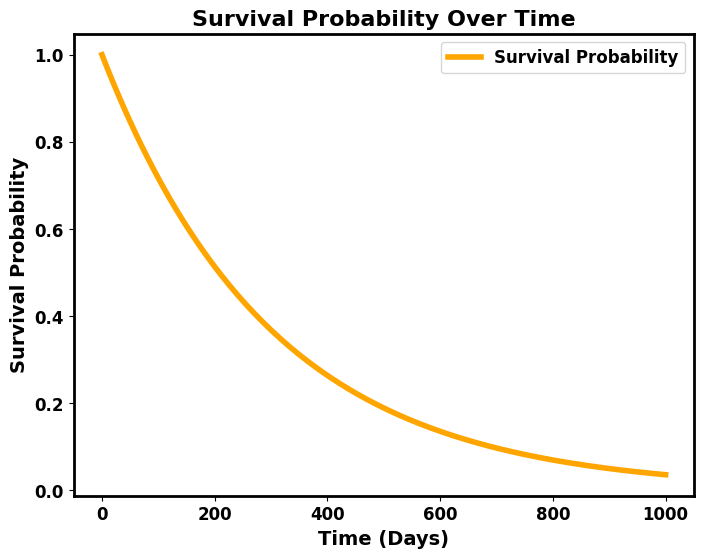

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Generate example data
time = np.linspace(0, 1000, 200)
survival_prob = np.exp(-time / 300)  # Exponential decay model

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(time, survival_prob, lw=4, color='orange', label="Survival Probability")

# Set axis labels with bold font
plt.xlabel("Time (Days)", fontsize=14, fontweight='bold')
plt.ylabel("Survival Probability", fontsize=14, fontweight='bold')
plt.title("Survival Probability Over Time", fontsize=16, fontweight='bold')

# Set tick parameters to be bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Make the axis spines (borders) bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Set legend text properties using the 'prop' argument
plt.legend(prop={'size': 12, 'weight': 'bold'})
# plt.grid(True)

plt.savefig('surviival.png')
plt.show()


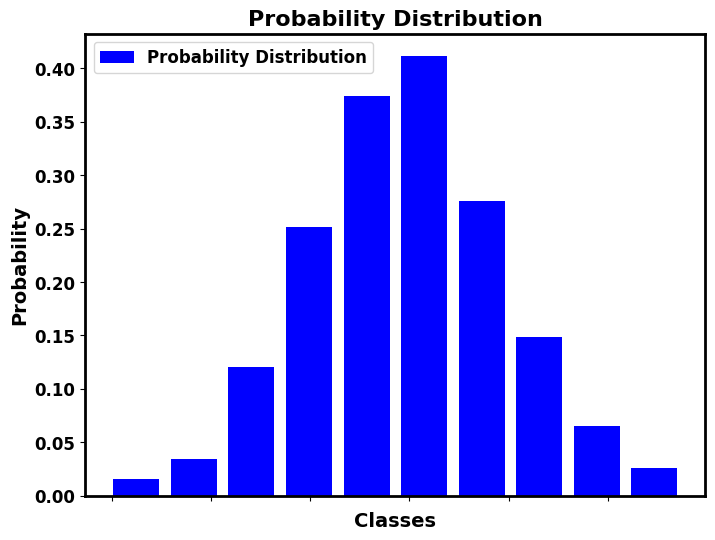

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data from a normal distribution
np.random.seed(0)
data = np.random.normal(loc=0, scale=1, size=1000)

# Compute histogram data with density=True to get a probability distribution
counts, bins = np.histogram(data, bins=10, density=True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Define a bar width slightly less than the bin width to create gaps between bars
bar_width = (bins[1] - bins[0]) * 0.8

# Create the bar plot with separated bars (using an edge color for clear boundaries)
plt.figure(figsize=(8, 6))
plt.bar(bin_centers, counts, width=bar_width, color='blue', linewidth=1.5, label='Probability Distribution')

# Set axis labels and title with bold styling
plt.xlabel("Classes", fontsize=14, fontweight='bold')
plt.ylabel("Probability", fontsize=14, fontweight='bold')
plt.title("Probability Distribution", fontsize=16, fontweight='bold')

# Set tick labels to be bold
plt.gca().set_xticklabels([])
plt.yticks(fontsize=12, fontweight='bold')

# Make the axis spines (borders) bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Set legend text properties using the 'prop' argument
plt.legend(prop={'size': 12, 'weight': 'bold'})
# plt.grid(True)

plt.savefig('histogram.png')

plt.show()


ValueError: x and y must have same first dimension, but have shapes (8,) and (7,)

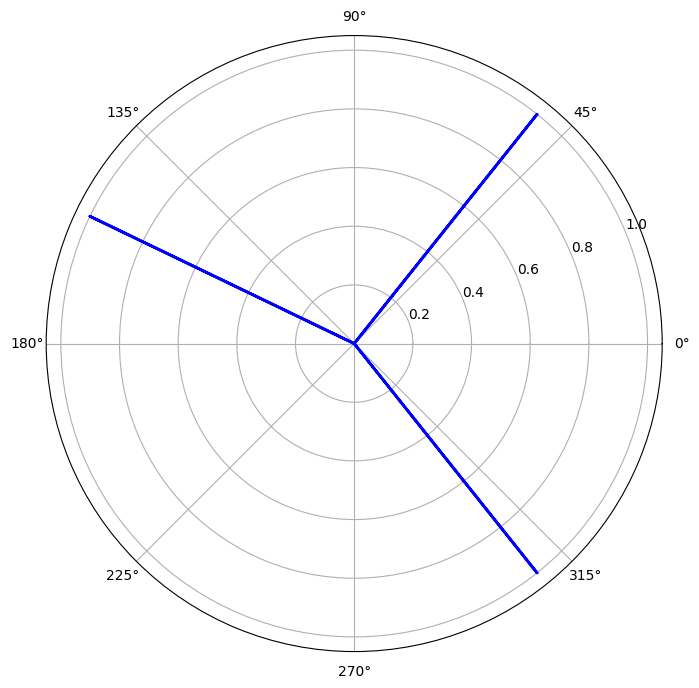

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define the labels (categories)
labels = ['Seg', 'Cls', 'Prog', 'CT scans', 'PET', 
          'Head and Neck', 'Chest']

# Number of variables (categories)
num_vars = len(labels)

# Example performance scores for three different models
model_1 = [0, 1, 0, 1, 0, 0, 1]
model_2 = [1, 1, 1, 1, 1, 1]

# Convert categories into angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the shape (loop back to first point)
model_1 += model_1[:1]
model_2 += model_2[:1]
angles += angles[:1]

# Create the figure
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot data for each model
ax.fill(angles, model_1, color='blue', alpha=0.25, label='Model 1')
ax.plot(angles, model_1, color='blue', linewidth=2)

ax.fill(angles, model_2, color='red', alpha=0.25, label='Model 2')
ax.plot(angles, model_2, color='red', linewidth=2)

ax.fill(angles, model_3, color='yellow', alpha=0.25, label='Model 3')
ax.plot(angles, model_3, color='yellow', linewidth=2)

# Add category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Show the plot
plt.show()
